In [1]:
import csv
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
torch.cuda.set_device(0)
device = torch.device("cuda")

In [3]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [4]:
dataset = torchvision.datasets.ImageFolder("./train/", transform=transform)
dataloader =torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataset[0][0].size()

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder("./test_all/", transform=transform)
testloader =torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


In [5]:
classes = dataset.classes

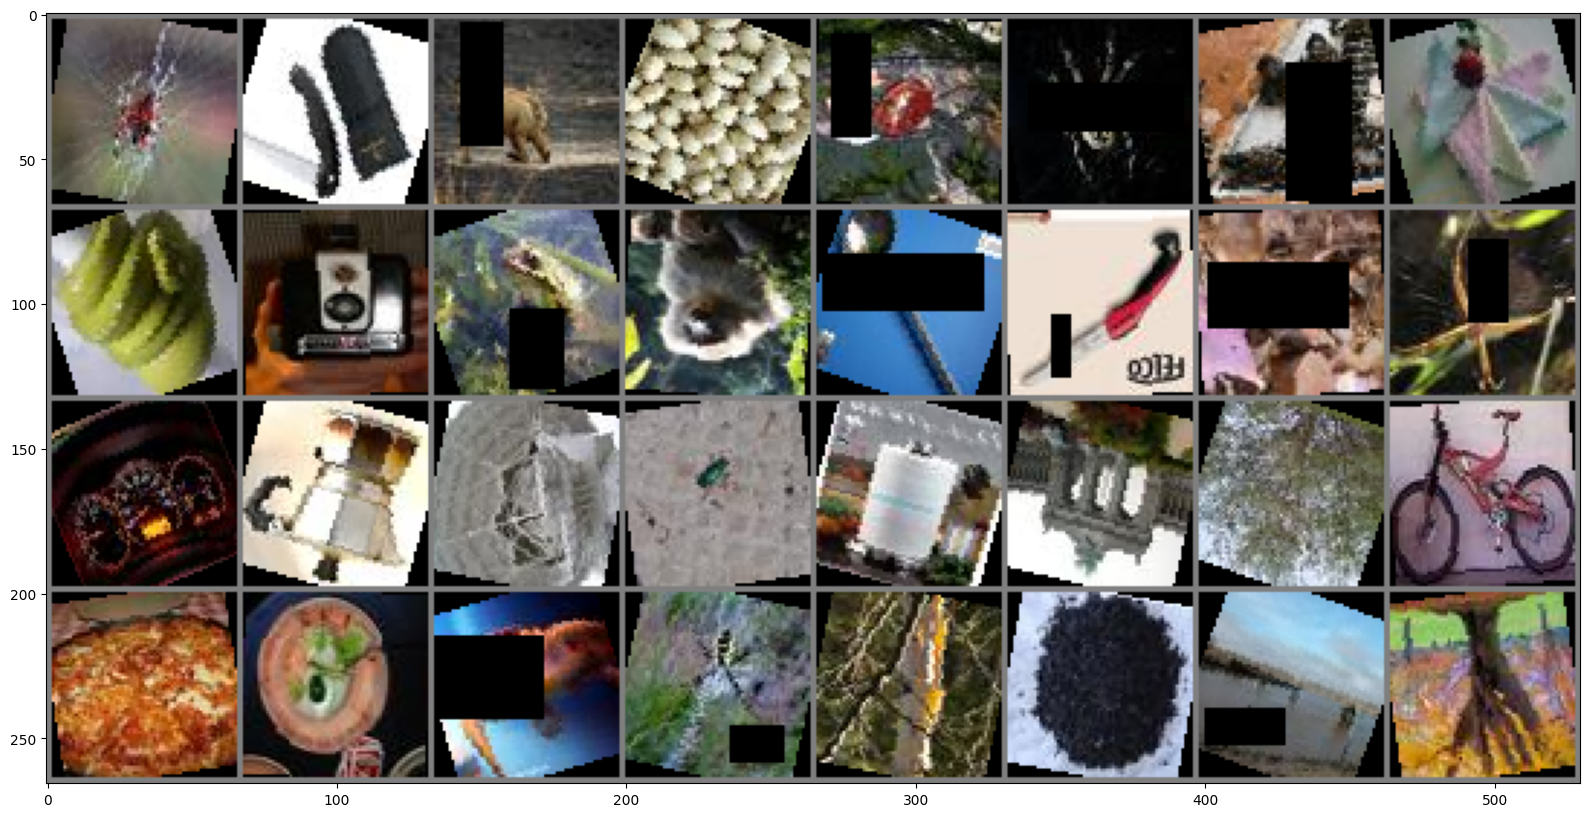

spider   saw swine  bean  crab spider crocodilian towel snake camera  frog monkey spoon   saw  frog spider gauge   pot antenna beetle towel memorial birch bicycle pizza icecream turtle spider birch carbon bridge birch


In [6]:
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
conv1(images[0:1]).size()

torch.Size([1, 6, 60, 60])

In [8]:
pool1 = nn.MaxPool2d(kernel_size=2)

In [9]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.resblock1 = ResNetBlock(64, 64)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.resblock2 = ResNetBlock(128, 128)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.resblock3 = ResNetBlock(256, 256)
        self.conv4 = nn.Conv2d(256, 512, 3)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.resblock4 = ResNetBlock(512, 512)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 50)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.resblock1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.resblock2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.resblock3(x)
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.resblock4(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

network = ResNet().to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [11]:
def train(num_iterations, trainloader):
    running_loss = 0.0
    network.train()
    for epoch in range(num_iterations):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print('[%d/%d] loss: %.3f' %
        (epoch+1, num_iterations,  running_loss/2000))
        running_loss = 0.0

    print('Finished Training')

In [12]:
train(num_iterations = 30, trainloader=trainloader)

[1/30] loss: 3.849
[2/30] loss: 3.512
[3/30] loss: 3.325
[4/30] loss: 3.170
[5/30] loss: 3.053
[6/30] loss: 2.964
[7/30] loss: 2.892
[8/30] loss: 2.839
[9/30] loss: 2.779
[10/30] loss: 2.723
[11/30] loss: 2.679
[12/30] loss: 2.640
[13/30] loss: 2.600
[14/30] loss: 2.558
[15/30] loss: 2.527
[16/30] loss: 2.499
[17/30] loss: 2.471
[18/30] loss: 2.443
[19/30] loss: 2.410
[20/30] loss: 2.382
[21/30] loss: 2.357
[22/30] loss: 2.330
[23/30] loss: 2.311
[24/30] loss: 2.286
[25/30] loss: 2.264
[26/30] loss: 2.246
[27/30] loss: 2.228
[28/30] loss: 2.213
[29/30] loss: 2.195
[30/30] loss: 2.178
Finished Training


In [13]:
def validate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += data.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples

    print('Validation Loss: {:.4f} | Accuracy: {:.4f}'.format(avg_loss, accuracy))
    return avg_loss, accuracy

In [14]:
validate(network, valloader)

Validation Loss: 2.0576 | Accuracy: 0.4386


(2.0575898329602014, 0.438561608816679)

In [15]:
def predict_classes(model, dataloader):
    predictions = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            print(outputs)
    return torch.tensor(predictions)

In [16]:
def test():
    predict = predict_classes(network, testloader).numpy()
    data = []
    
    for idx, filename in enumerate(os.listdir('test_all/test_all/')):
        data.append((filename, predict[idx]))

    with open('results.csv', 'a', newline="") as file:
        writer = csv.writer(file, delimiter=' ')

        for row in data:
            writer.writerow(row)
    
test()

tensor([[ -5.5663,  -8.2698,  -3.7402,  ...,  -7.5329,  -5.6396,   0.1460],
        [ -2.8202,  -1.6607,  -5.2181,  ...,  -4.7843,  -8.1926,  -5.0518],
        [ -6.6681,  -7.5768,  -0.3401,  ..., -10.7223,  -6.5058,  -2.6150],
        ...,
        [-10.8626,  -6.0986,  -6.9696,  ..., -26.8708, -18.6660,  -3.2577],
        [ -6.5563,  -7.5117,  -4.5012,  ..., -10.4460, -10.4664,  -2.7748],
        [ -0.8834,  -4.9500,  -3.7258,  ...,  -2.9355,  -5.5951,  -4.2068]],
       device='cuda:0')
tensor([[-2.9712, -4.8480, -4.6873,  ..., -1.9475, -3.7283, -2.0255],
        [-5.3941, -4.1091, -2.5382,  ..., -7.4220,  1.6537, -1.5669],
        [-1.7613, -3.8839, -5.3151,  ..., -2.1578, -0.4177, -4.2173],
        ...,
        [-0.9970, -2.9448, -1.9947,  ..., -2.3145, -0.5785, -1.3469],
        [-3.9903, -8.3896, -5.6539,  ..., -5.7420, -4.5280, -3.3415],
        [-1.8777, -3.5814, -3.3453,  ..., -7.8102, -4.9833, -3.9206]],
       device='cuda:0')
tensor([[ -4.1614,  -1.7429,  -4.8645,  ...,  -1